In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time
import data_manipulator
import create_model
import data_reader
import finance_calculator

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.titlesize"] = 17
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [68]:
# load back history data
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
ASSET_TO_PREDICT = 'rx1'                  #--- VAR CHANGE
with open('models/last_run_model_name.txt') as f:
    last_model_name = f.readline()
    print(last_model_name)
model_name = last_model_name        #--- VAR CHANGE
model_load = keras.models.load_model(f'models/{model_name}.hdf5')
history_load = np.load(f'history/{model_name}.npy',allow_pickle='TRUE').item()

01.17.1706-rx1-60-1


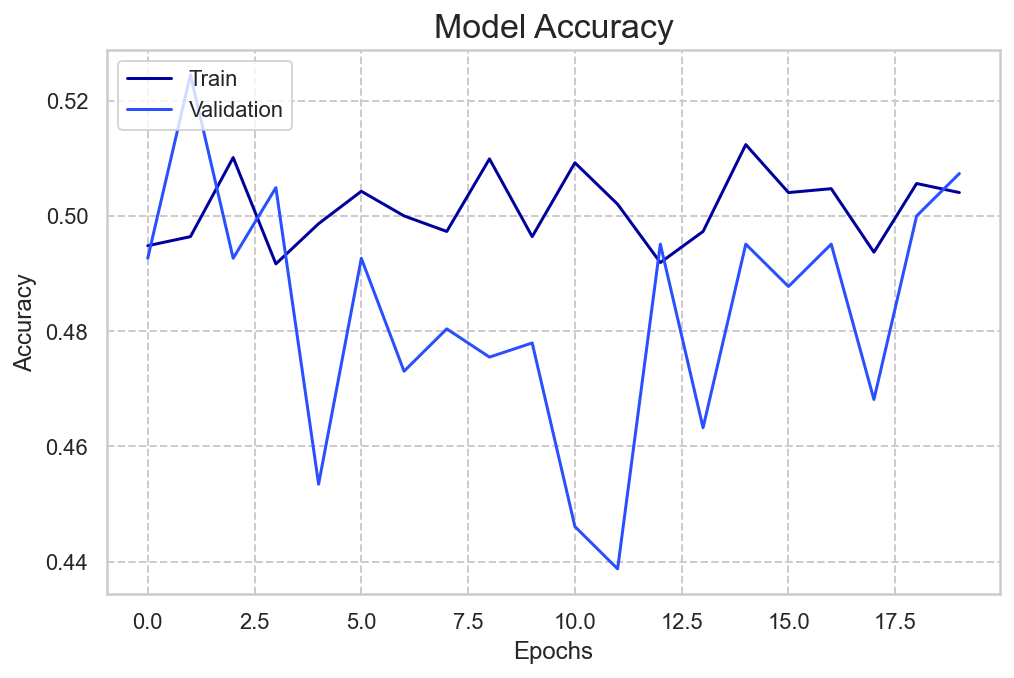

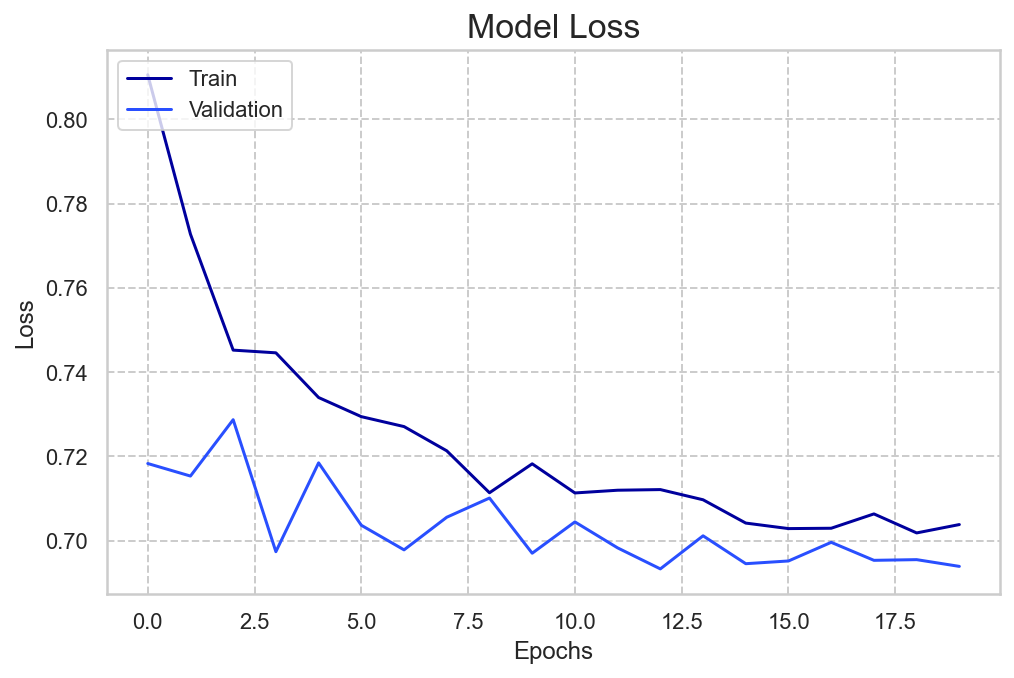

In [69]:
fig1, axs1, fig2, axs2 = utils.plot_history_data(history_load)

In [70]:
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = data_reader.credit()
credit_df['rx1'] = rx1['RX1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]
crypto_df = data_reader.crypto(ratios)

# set dataset                              
dataset_df = credit_df                      # --VAR CHANGE 

val_df = data_manipulator.splitter(dataset_df, cutoff=0.10)[1]

df_rp = utils.getReturnAndPred_sigmoidModel(val_df, SEQ_LEN+1, ASSET_TO_PREDICT, model_load)

[0.4752949]
[0.47807705]
[0.4791574]
[0.4783412]
[0.4785178]
[0.47705045]
[0.47596815]
[0.47597218]
[0.47677356]
[0.47589192]
[0.47598752]
[0.47959703]
[0.48021808]
[0.47778362]
[0.4755866]
[0.4757872]
[0.47540632]
[0.47407594]
[0.47624835]
[0.47883323]
[0.47685367]
[0.48147923]
[0.4778976]
[0.47722906]
[0.47749358]
[0.48093885]
[0.48015934]
[0.47755367]
[0.48162007]
[0.48378164]
[0.4831128]
[0.4816681]
[0.48020092]
[0.4788782]
[0.47945407]
[0.48187625]
[0.4828096]
[0.48268402]
[0.4836761]
[0.48354197]
[0.48206484]
[0.48165143]
[0.4824405]
[0.48391297]
[0.48240486]
[0.47771284]
[0.47556424]
[0.47540244]
[0.47470942]
[0.47490007]
[0.47528762]
[0.47488937]
[0.47423345]
[0.47347018]
[0.47377858]
[0.47296268]
[0.47284758]
[0.47363976]
[0.47552094]
[0.4753209]
[0.47528738]
[0.47401658]
[0.48189563]
[0.47236046]
[0.47440964]
[0.472995]
[0.47545028]
[0.4785514]
[0.4772898]
[0.47687703]
[0.47753498]
[0.4763963]
[0.48419502]
[0.47982395]
[0.4773787]
[0.484881]
[0.48158318]
[0.4761888]
[0.482507

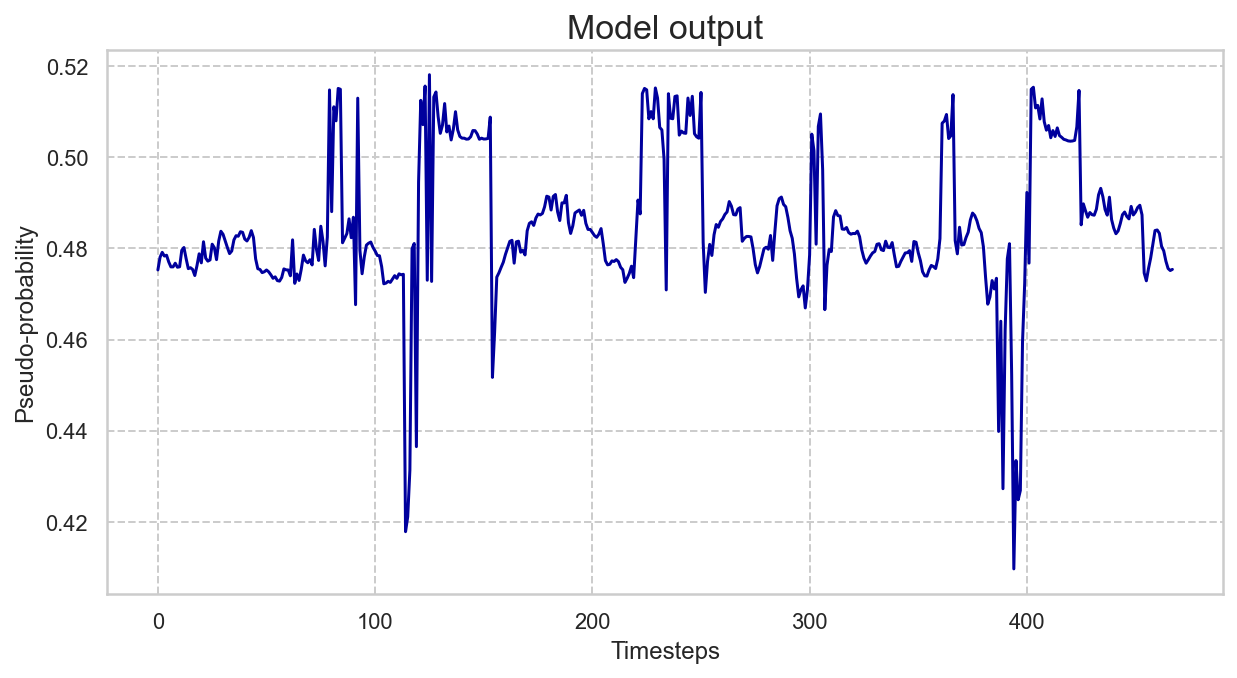

In [71]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
fig = plt.plot(df_rp['pred[0]'])
axs = plt.title('Model output')
axs = plt.ylabel('Pseudo-probability')
axs = plt.xlabel('Timesteps')

Mean of 50 first predictions 0.47881424
TP: 76
FP: 83
TN: 176
FN: 133
Precision: 47.80%
Recall: 36.36%
Correlation: -95.07%


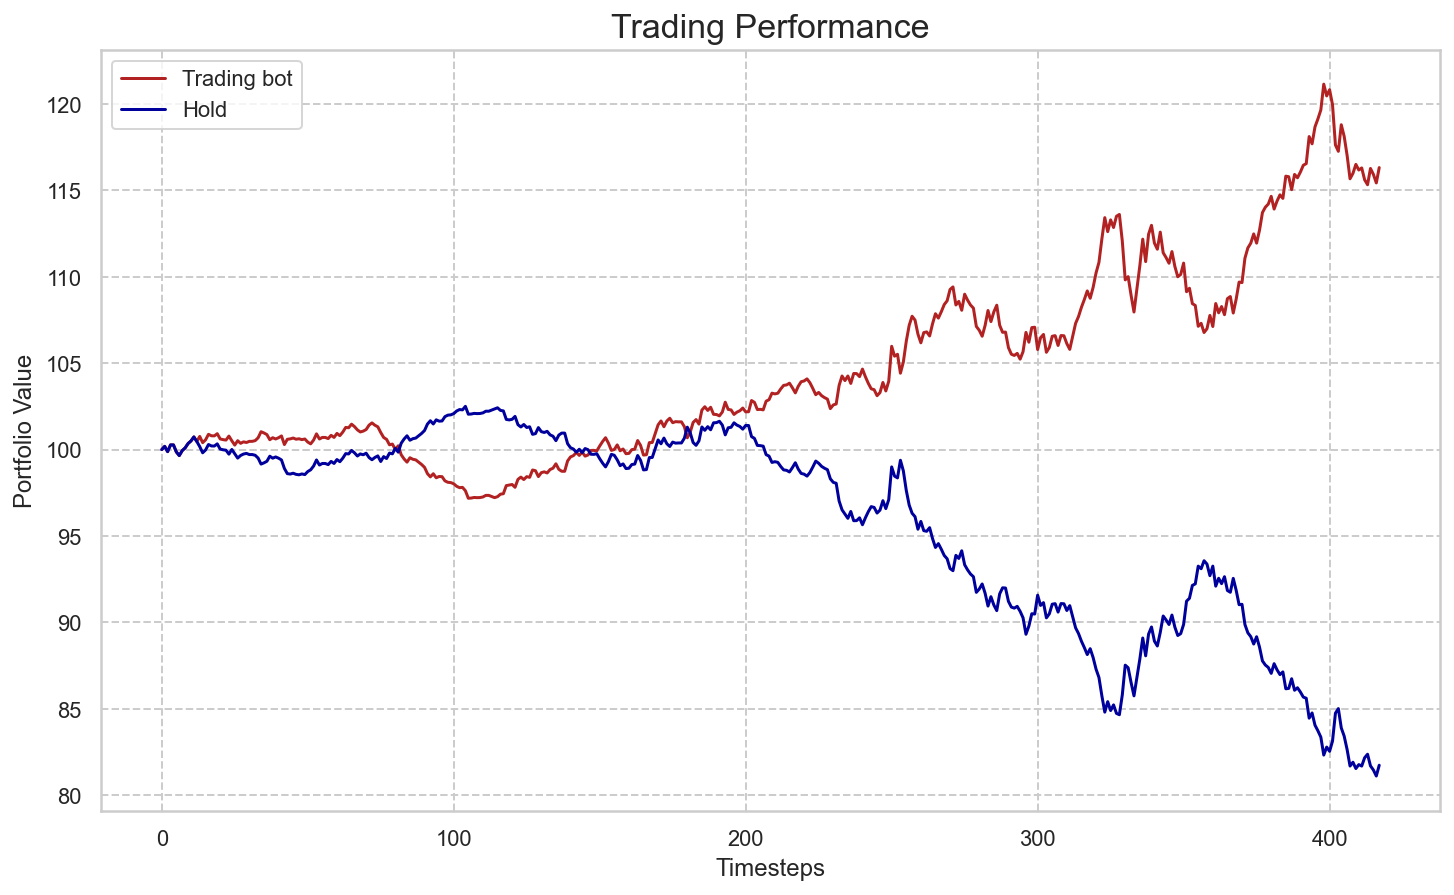

In [124]:
n = 50                       #--- VAR CHANGE
first_n_predictions = df_rp.loc[0:n, 'pred[0]']
mean = np.mean(first_n_predictions)
print(f'Mean of {n} first predictions', mean)

treshhold = mean # 0 = always short, 1 = always long. mean ~ 50/50 short/long
copy_df = df_rp[n:].reset_index(drop=True)
portfolio_value_trading = finance_calculator.portfolio_value_trading(copy_df, treshhold)
portfolio_value_hold = finance_calculator.portfolio_value_hold(copy_df)

fig, axs = plt.subplots(1,1, figsize=(12,7))
fig = plt.plot(portfolio_value_trading, color='firebrick', linestyle='-')
fig = plt.plot(portfolio_value_hold)
axs1 = plt.title('Trading Performance', )
axs1 = plt.ylabel('Portfolio Value')
axs1 = plt.xlabel('Timesteps')
axs1 = plt.legend(['Trading bot', 'Hold'], loc='upper left')

tp, fp, tn, fn = finance_calculator.confusion_stats_trading(df_rp, treshhold)
print(f'TP: {tp}'); print(f'FP: {fp}'); print(f'TN: {tn}'); print(f'FN: {fn}')

precision = tp / (tp + fp) #of the positive predictions, how many are correct?
recall = tp / (tp + fn) #how many of the positives did we recall?
print("Precision: {:5.2f}%".format(100 * precision))
print("Recall: {:5.2f}%".format(100 * recall))

correlation = np.corrcoef(portfolio_value_trading, portfolio_value_hold)[1][0]
print("Correlation: {:5.2f}%".format(100 * correlation))

In [117]:
returns_trading = finance_calculator.daily_returns(portfolio_value_trading)
sharpe_trading = finance_calculator.sharpe_ratio(returns_trading, 1440*365, 0.02)
sortino_trading = finance_calculator.sortino_ratio(returns_trading, 1440*365, 0.02)
print("Sharpe-ratio, trading: {:5.2f}".format(sharpe_trading))
print("Sortino-ratio, trading: {:5.2f}".format(sortino_trading))
gross_return_trading = finance_calculator.gross_return(portfolio_value_trading)
print("Gross return, trading: {:5.2f}%".format(100 * gross_return_trading))

print('')

returns_hold = finance_calculator.daily_returns(portfolio_value_hold)
sharpe_hold = finance_calculator.sharpe_ratio(returns_hold, 1440*365, 0.02)
sortino_hold = finance_calculator.sortino_ratio(returns_hold, 1440*365, 0.02)
print("Sharpe-ratio, hold: {:5.2f}".format(sharpe_hold))
print("Sortino-ratio, hold: {:5.2f}".format(sortino_hold))
gross_return_hold = finance_calculator.gross_return(portfolio_value_hold)
print("Gross return, hold: {:5.2f}%".format(100 * gross_return_hold))


Sharpe-ratio, trading: 54.85
Sortino-ratio, trading: 79.95
Gross return, trading: 16.32%

Sharpe-ratio, hold: -69.10
Sortino-ratio, hold: -108.76
Gross return, hold: -18.27%
